In [1]:
import os
import sys
from collections import defaultdict

import pydicom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing, binary_erosion  # Morphological operator

MRI_FRAMES = 50
MRI_MIN_RADIUS = 2
MRI_MAX_MYOCARDIUM = 20
MRI_BIG_RADIUS_FACTOR = 0.9
MRI_SMALL_RADIUS_FACTOR = 0.19
MRI_SEGMENTED_CHANNEL_MAP = {'background': 0, 'ventricle': 1, 'myocardium': 2}

In [2]:
!rm -rf ./dcm_scratch/
!mkdir ./dcm_scratch/
!cp /mnt/disks/sax-mri-zip/1000387_20209_2_0.zip ./dcm_scratch/
!unzip ./dcm_scratch/1000387_20209_2_0.zip -d ./dcm_scratch/

Archive:  ./dcm_scratch/1000387_20209_2_0.zip
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512869723579391.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512875285379399.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512989554179454.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512840686479375.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512872296479395.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512960981879439.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512995575879460.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512840153979374.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512843747479382.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512844179879383.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217512899890379406.dcm

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521978677579815.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521912806379769.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521978273579814.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217522012245479831.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217522034094879839.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217522065335879855.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521942375879790.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521947377779800.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217521974884879811.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217522035178079841.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121752204792779824.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531720231881366.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531724124681390.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531726066081402.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121753172814281297.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531733233781446.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531735511881460.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531748253781538.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531749233681544.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.20180112175317936181287.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531533106380427.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531542213180485.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.1

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531760333581612.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531545305680505.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531557637080569.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531562441180593.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531565305880607.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531584718880703.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531591589380737.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531593203480745.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531596034280759.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531597661780767.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531613080880843.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531755127881580.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531755449781582.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531548085380521.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531553710780549.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531561595980589.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531578254080671.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531580677880683.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531594011680749.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531615534780855.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531622081280887.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531643079680989.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531563279780597.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531576232280661.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531576637080663.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531579869180679.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531581887280689.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531585928780709.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531586736180713.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531598066380769.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531611447580835.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531615941380857.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531633968780945.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531536210980447.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531553322880547.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531558815180575.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531563683680599.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531572177280641.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531598473080771.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531625347080903.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531632737880939.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121753163321380795.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531638151880965.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217531641437880981.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485840213978241.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485725680078182.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485871583878259.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485814301278230.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121748589319078224.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485754228578198.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485780094178210.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485838974678238.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485864639478250.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485748902878194.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217485760223878200.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501283343678794.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501289242878797.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501316728778813.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501345780578829.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501324388778816.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121750146239978862.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501255910178778.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501258647678781.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501317181478814.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121750143265578856.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217501261117278784.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510482287679256.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.201801121751059721579268.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510366457379200.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510395012679213.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510362322279194.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510454224779243.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510482676679257.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510331159679173.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510333804979181.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510453259579241.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.141243.2018011217510483638379258.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2

In [3]:

dcm_dir = './dcm_scratch/'
series = defaultdict(list)
for dcm_file in os.listdir(dcm_dir):
    if not dcm_file.endswith('.dcm'):
        continue
    dcm = pydicom.read_file(dcm_dir + dcm_file)
    if 'cine_segmented_sax_inlinevf' == dcm.SeriesDescription.lower():
        cur_angle = (dcm.InstanceNumber - 1) // MRI_FRAMES 
        series[cur_angle].append(dcm)
print('len is:' , len(series))
for k in series:
    print(len(series[k]))

len is: 12
50
50
50
50
50
50
50
50
50
50
50
50


In [4]:
MRI_MIN_RADIUS = 2
MRI_MAX_MYOCARDIUM = 20
MRI_BIG_RADIUS_FACTOR = 0.9
MRI_SMALL_RADIUS_FACTOR = 0.19
MRI_SEGMENTED_CHANNEL_MAP = {'background': 0, 'ventricle': 1, 'myocardium': 2}
def _is_mitral_valve_segmentation(d) -> bool:
    return d.ImagePositionPatient[0] < 0

def _get_overlay_from_dicom(d, debug=False):
    """Get an overlay from a DICOM file

    Morphological operators are used to transform the pixel outline of the myocardium
    to the labeled pixel masks for myocardium and left ventricle

    Arguments
        d: the dicom file
        stats: Counter to keep track of summary statistics

    Returns
        Tuple of two numpy arrays.
        The first is the raw overlay array with myocardium outline,
        The second is a pixel mask with 0 for background 1 for myocardium and 2 for ventricle
    """
    i_overlay = 0
    dicom_tag = 0x6000 + 2 * i_overlay
    overlay_raw = d[dicom_tag, 0x3000].value
    rows = d[dicom_tag, 0x0010].value  # rows = 512
    cols = d[dicom_tag, 0x0011].value  # cols = 512
    overlay_frames = d[dicom_tag, 0x0015].value
    bits_allocated = d[dicom_tag, 0x0100].value

    np_dtype = np.dtype('uint8')
    length_of_pixel_array = len(overlay_raw)
    expected_length = rows * cols
    if bits_allocated == 1:
        expected_bit_length = expected_length
        bit = 0
        overlay = np.ndarray(shape=(length_of_pixel_array * 8), dtype=np_dtype)
        for byte in overlay_raw:
            for bit in range(bit, bit + 8):
                overlay[bit] = byte & 0b1
                byte >>= 1
            bit += 1
        overlay = overlay[:expected_bit_length]
    if overlay_frames == 1:
        overlay = overlay.reshape(rows, cols)
        idx = np.where(overlay == 1)
        min_pos = (np.min(idx[0]), np.min(idx[1]))
        max_pos = (np.max(idx[0]), np.max(idx[1]))
        short_side = min((max_pos[0] - min_pos[0]), (max_pos[1] - min_pos[1]))
        small_radius = max(MRI_MIN_RADIUS, short_side * MRI_SMALL_RADIUS_FACTOR)
        big_radius = max(MRI_MIN_RADIUS+1, short_side * MRI_BIG_RADIUS_FACTOR)
        small_structure = _unit_disk(small_radius)
        m1 = binary_closing(overlay, small_structure).astype(np.int)
        big_structure = _unit_disk(big_radius)
        m2 = binary_closing(overlay, big_structure).astype(np.int)
        anatomical_mask = m1 + m2
        ventricle_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['ventricle'])
        myocardium_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['myocardium'])
        if ventricle_pixels == 0 and myocardium_pixels > MRI_MAX_MYOCARDIUM:
            erode_structure = _unit_disk(small_radius*1.5)
            anatomical_mask = anatomical_mask - binary_erosion(m1, erode_structure).astype(np.int)
            ventricle_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['ventricle'])
            print(f"rescue ventricle_pixels {ventricle_pixels} myo pixels: {myocardium_pixels} ")
        return overlay, anatomical_mask, ventricle_pixels
    
def _unit_disk(r) -> np.ndarray:
    y, x = np.ogrid[-r: r + 1, -r: r + 1]
    return (x ** 2 + y ** 2 <= r ** 2).astype(np.int)


def _outline_to_mask(labeled_outline, idx) -> np.ndarray:
    idx = np.where(labeled_outline == idx)
    poly = list(zip(idx[1].tolist(), idx[0].tolist()))
    img = Image.new("L", [labeled_outline.shape[1], labeled_outline.shape[0]], 0)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

In [17]:
def plot_b_series(b_series, sides=7):
    _, axes = plt.subplots(sides, sides, figsize=(18, 24))
    for dcm in b_series:
        idx = (dcm.InstanceNumber-1)%50
        if idx >= sides*sides:
            continue
        if _is_mitral_valve_segmentation(dcm):
            axes[idx%sides, idx//sides].imshow(dcm.pixel_array)
        else:
            try:
                overlay, anatomical_mask, ventricle_pixels = _get_overlay_from_dicom(dcm)
                axes[idx%sides, idx//sides].imshow(np.ma.masked_where(anatomical_mask == 2, dcm.pixel_array))
            except KeyError:
                print(f'could get overlay at {dcm.InstanceNumber}, angle {s}')
                axes[idx, idx//sides].imshow(dcm.pixel_array)
        axes[idx%sides, idx//sides].set_yticklabels([])
        axes[idx%sides, idx//sides].set_xticklabels([])

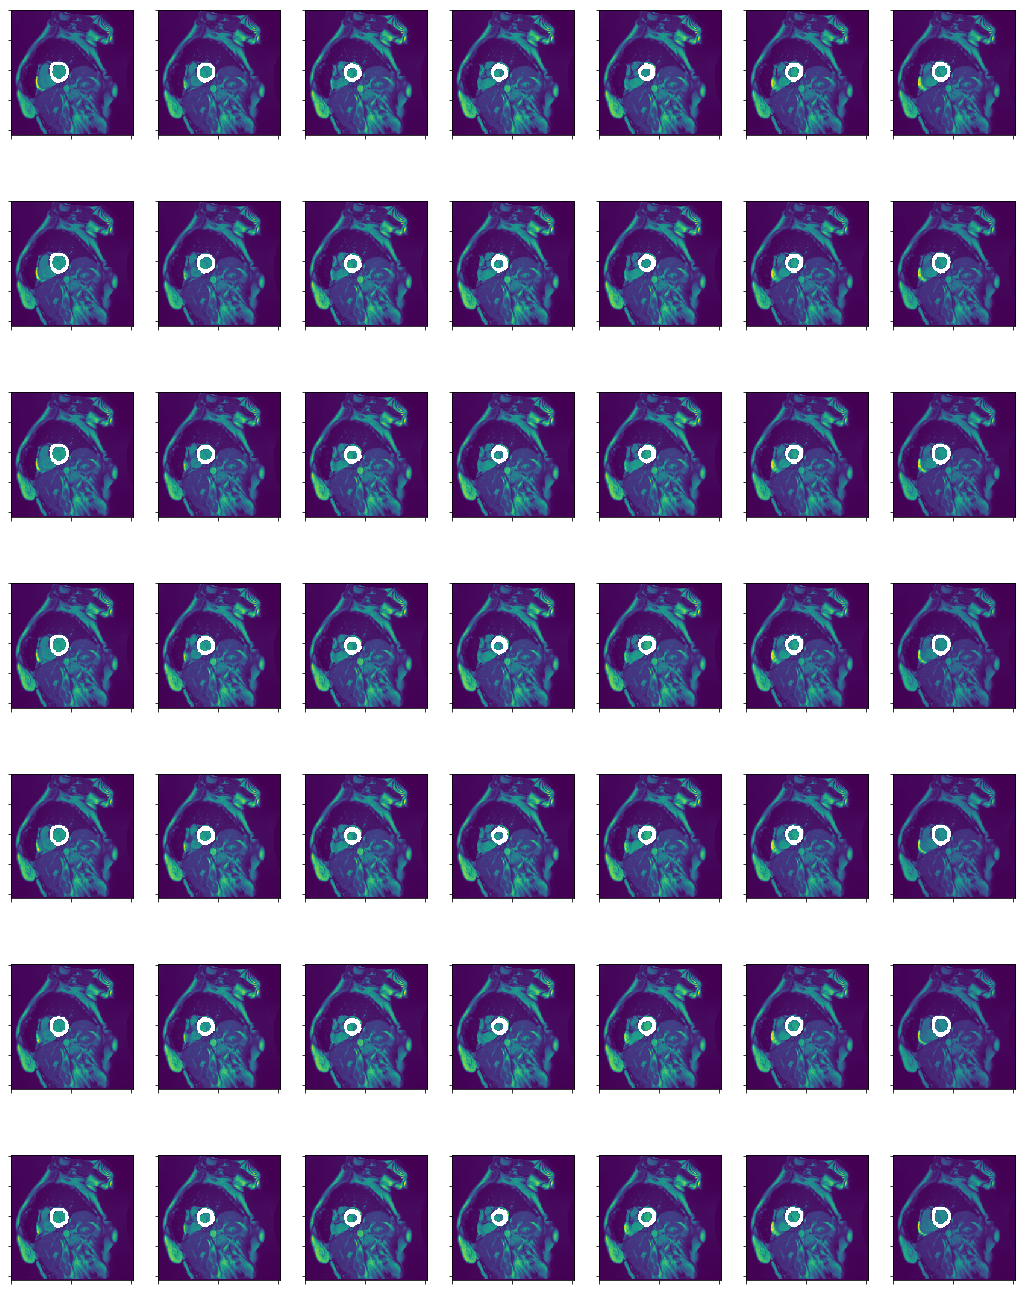

In [18]:
plot_b_series(series[2], sides=7)

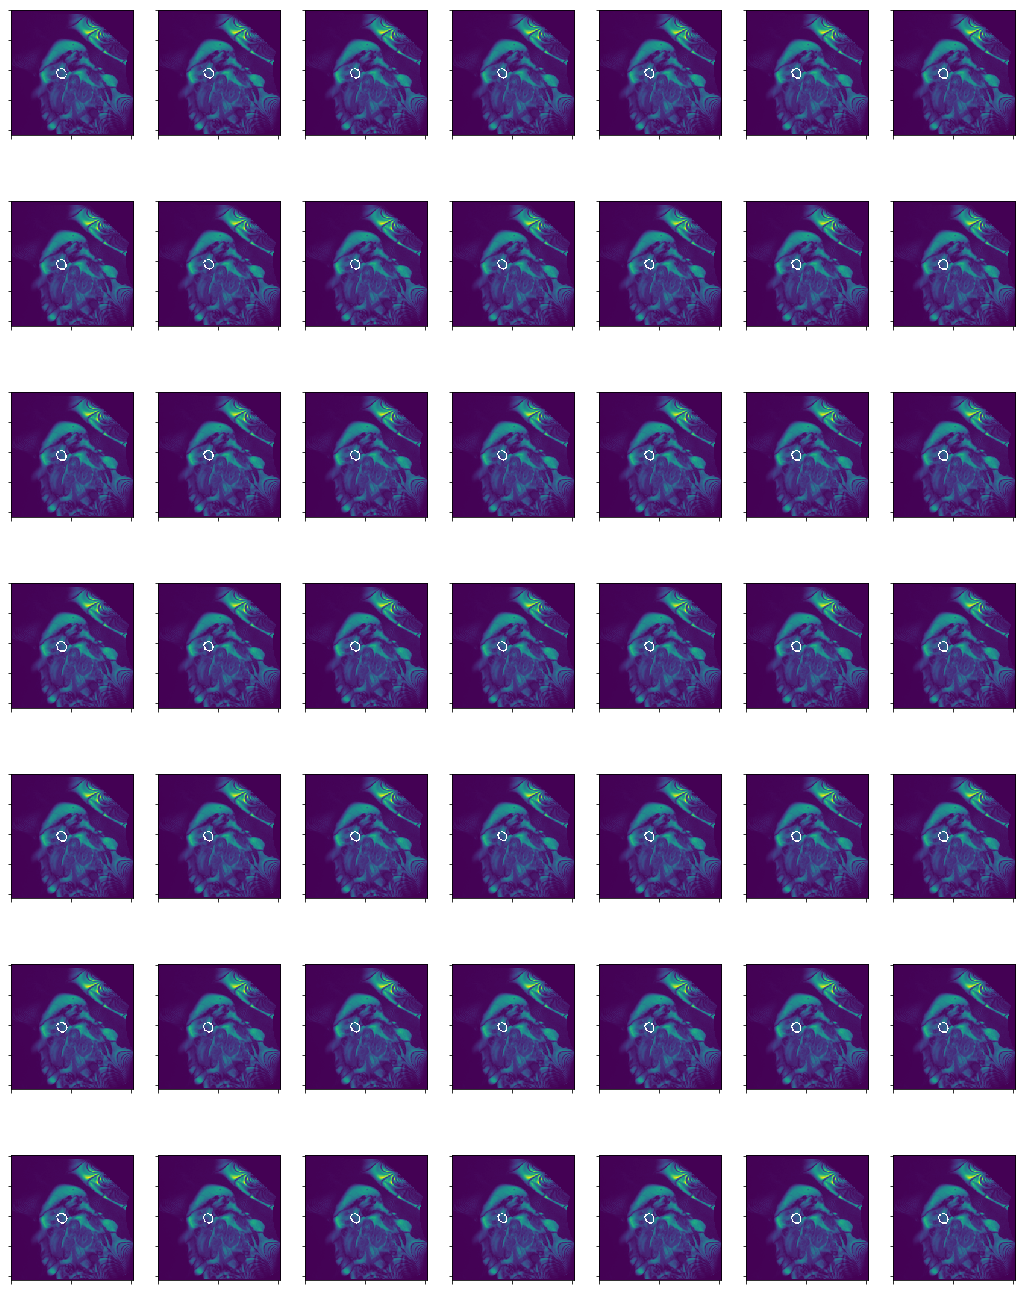

In [19]:
plot_b_series(series[8], sides=7)

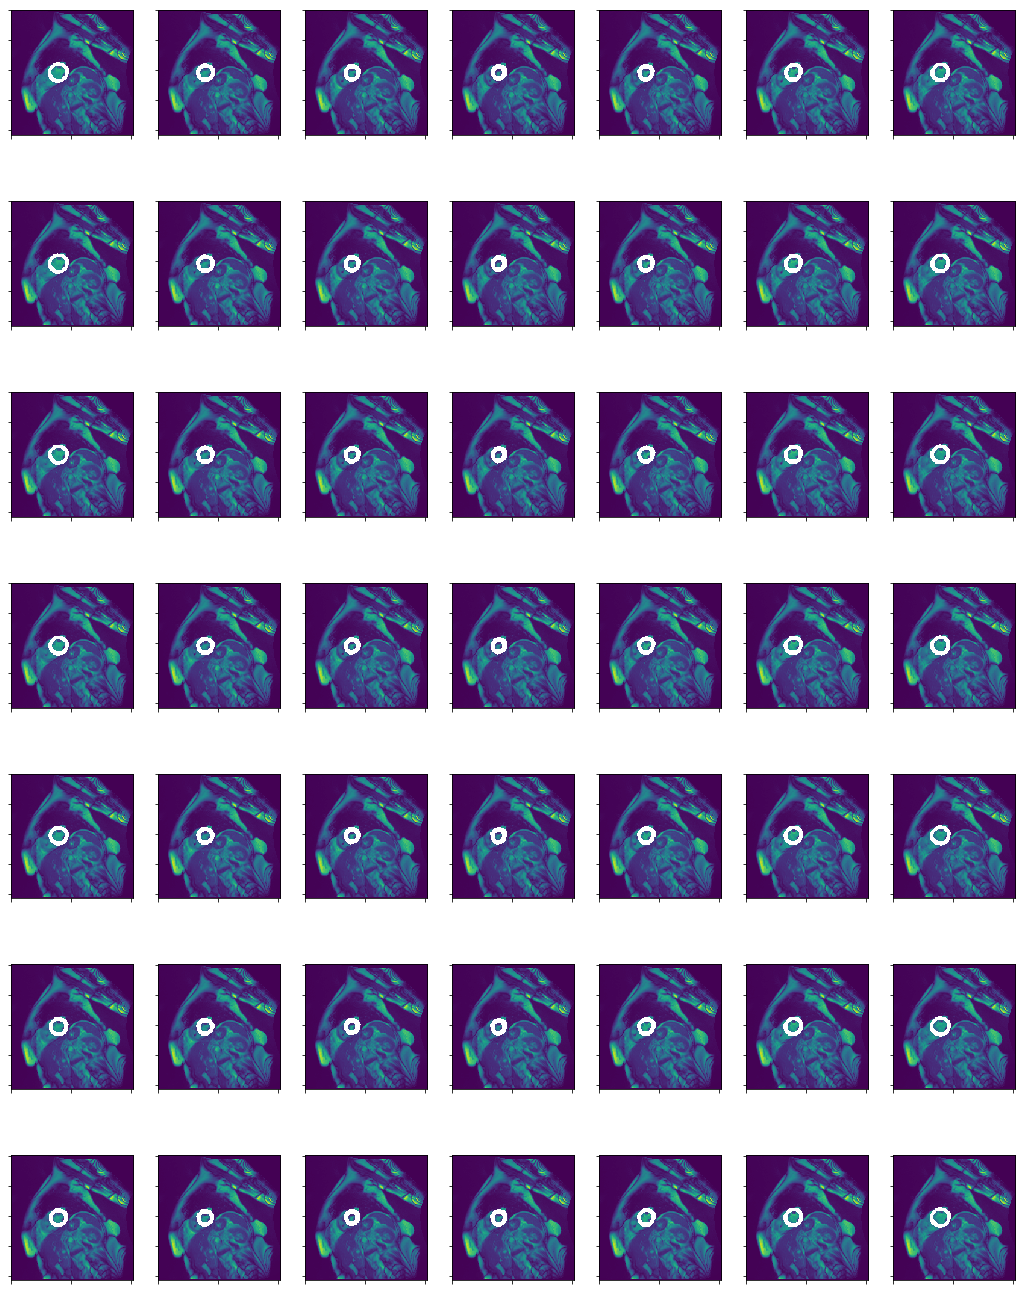

In [20]:
plot_b_series(series[5], sides=7)

rescue ventricle_pixels 81 myo pixels: 348 
rescue ventricle_pixels 78 myo pixels: 341 
rescue ventricle_pixels 88 myo pixels: 338 
rescue ventricle_pixels 76 myo pixels: 339 
rescue ventricle_pixels 85 myo pixels: 357 
rescue ventricle_pixels 85 myo pixels: 353 
rescue ventricle_pixels 99 myo pixels: 357 
rescue ventricle_pixels 100 myo pixels: 361 
rescue ventricle_pixels 75 myo pixels: 336 
rescue ventricle_pixels 88 myo pixels: 361 
rescue ventricle_pixels 85 myo pixels: 355 
rescue ventricle_pixels 86 myo pixels: 380 
rescue ventricle_pixels 84 myo pixels: 333 
rescue ventricle_pixels 75 myo pixels: 337 
rescue ventricle_pixels 96 myo pixels: 355 
rescue ventricle_pixels 105 myo pixels: 366 
rescue ventricle_pixels 91 myo pixels: 342 
rescue ventricle_pixels 96 myo pixels: 357 
rescue ventricle_pixels 94 myo pixels: 371 
rescue ventricle_pixels 104 myo pixels: 365 
could get overlay at 10, angle 0
could get overlay at 4, angle 0
could get overlay at 25, angle 0
could get overlay a

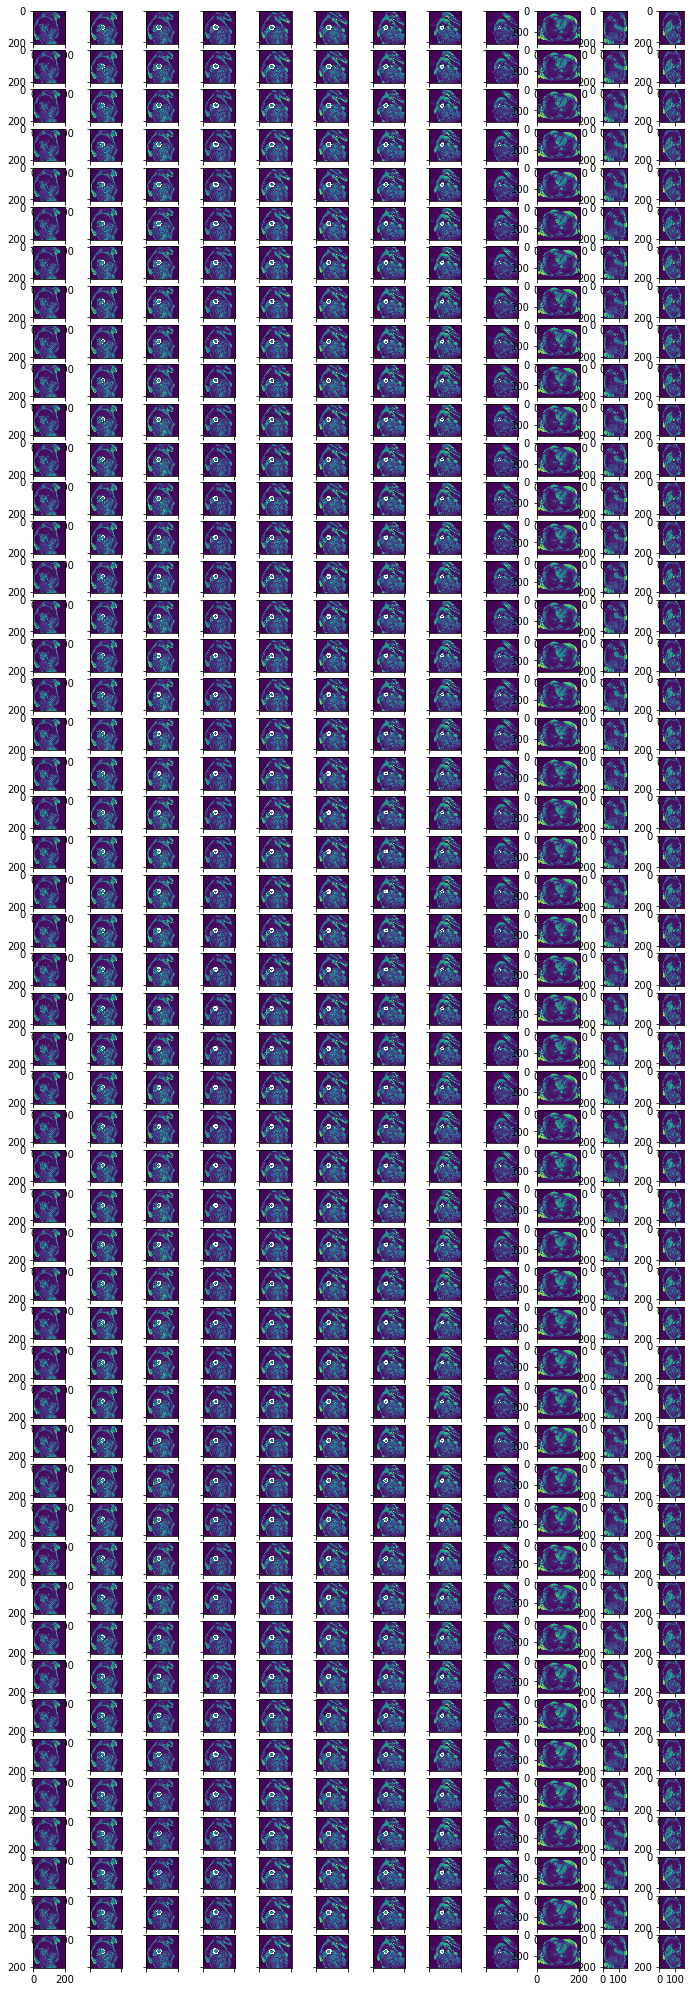

In [23]:
systoles = {}
diastoles = {}
systoles_pix = {}
diastoles_pix = {}
_, axes = plt.subplots(50, 12, figsize=(12, 36))
for s in series:
    for dcm in series[s]:
        if _is_mitral_valve_segmentation(dcm):
            axes[(dcm.InstanceNumber-1)%50, s].imshow(dcm.pixel_array)
            continue
        try:
            overlay, anatomical_mask, ventricle_pixels = _get_overlay_from_dicom(dcm)
            axes[(dcm.InstanceNumber-1)%50, s].imshow(np.ma.masked_where(anatomical_mask == 2, dcm.pixel_array))
            axes[(dcm.InstanceNumber-1)%50, s].set_yticklabels([])
            axes[(dcm.InstanceNumber-1)%50, s].set_xticklabels([])
        except KeyError:
            print(f'could get overlay at {dcm.InstanceNumber}, angle {s}')
            axes[(dcm.InstanceNumber-1)%50, s].imshow(dcm.pixel_array)
        if s not in diastoles:
            diastoles[s] = dcm
            diastoles_pix[s] = ventricle_pixels
            systoles[s] = dcm
            systoles_pix[s] = ventricle_pixels
        else:
            if ventricle_pixels > diastoles_pix[s]:
                diastoles[s] = dcm
                diastoles_pix[s] = ventricle_pixels
            if ventricle_pixels < systoles_pix[s]:
                systoles[s] = dcm
                systoles_pix[s] = ventricle_pixels

for angle in diastoles:
    print(f'Found systole at instance {systoles[angle].InstanceNumber}  pix: {systoles_pix[angle]}')
    print(f'Found diastole at instance {diastoles[angle].InstanceNumber}   pix: {diastoles_pix[angle]}\n')

In [6]:
print (series.keys())

dict_keys([7, 4, 11, 6, 3, 5, 0, 10, 8, 1, 9, 2])
